# Exploring Hoffman Stochastic VI

In [98]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from copy import deepcopy

from valez_finite_VI_lib import *


# Draw data

In [99]:
#np.random.seed(43141) 
np.random.seed(234213)

Num_samples = 500 # sample size
D = 2 # dimension
# so X will be a N\times D matrix

K_inf = 3 # take to be large for a good approximation to the IBP

alpha = 10 # IBP parameter

# Parameters to draw A from MVN
sigma_eps = .1 # variance of noise
sigma_A = 100

# generate data
Pi, Z, mu, A, X = generate_data(Num_samples, D, K_inf, sigma_A, sigma_eps, alpha)



# Set initializations 

In [112]:
# set initializations
K_approx = deepcopy(K_inf) # variational truncation
tau, nu, phi_mu, phi_var = initialize_parameters(Num_samples, D, K_approx)

Data_shape = {'D':D, 'N': Num_samples , 'K':K_approx}
sigmas = {'eps': sigma_eps, 'A': sigma_A}

"""print(X[0:10,:])
print(tau)
print(phi_mu)
print(nu[0:10,:])
"""

'print(X[0:10,:])\nprint(tau)\nprint(phi_mu)\nprint(nu[0:10,:])\n'

# run stochastic VI

In [113]:
def add_noise_to_phi(phi_mu, noise_scale):
    phi_mu[:] = phi_mu + np.random.normal(0, noise_scale, phi_mu.shape)
    

In [105]:
print(phi_mu)
add_noise_to_phi(phi_mu, 0.1 * sigma_A)
print(phi_mu)

[[ 18.74452139  17.82522451  -3.6803414 ]
 [ -4.96835875  -5.7507514   -7.56192761]]
[[ 25.36414532  18.61133723 -15.98997685]
 [ 10.31032369   3.87202299  -7.88964553]]


In [114]:
iter_ran = 0

In [115]:
iterations = 1000
elbo = np.zeros(iterations)

batch_size = Num_samples / 50
assert batch_size % 1 == 0  # make sure this is an integer
batch_size = int(batch_size)

for i in range(iterations): 
    # sample data
    indices = np.random.choice(Num_samples, size = batch_size, replace = False)
    

    # update local parameters: in this case, nu
    digamma_tau = sp.special.digamma(tau)
    for n in indices: 
        for k in range(K_approx): 
            nu_updates(tau, nu, phi_mu, phi_var, X, sigmas, n, k, digamma_tau)

    # replicate data
    replicates = Num_samples/batch_size 
    # the method below will only work when Num_samples is a multiple of batch_size
    assert Num_samples%batch_size == 0 
    
    replicates = int(replicates)
    
    nu_stochastic = np.zeros((Num_samples, K_approx))
    X_stochastic = np.zeros((Num_samples, D))
    for j in range(batch_size): 
        nu_stochastic[j*replicates:(j+1)*replicates , :] = nu[indices[j], :]
        X_stochastic[j*replicates:(j+1)*replicates , :] = X[indices[j], :]
    
    """ print(nu[indices, :])
        print(X[indices, :])
        print(nu_stochastic)
        print(X_stochastic)
    """ 
        
    # update global paremeters: phi_mu, phi_var, and tau
    
    step_size = (iter_ran+1)**(-0.9)
    
    for k in range(K_approx): 
        phi_mu_old = deepcopy(phi_mu)
        phi_var_old = deepcopy(phi_var)

        phi_updates(nu_stochastic, phi_mu, phi_var, X_stochastic, sigmas, k)
        
        phi_mu = phi_mu_old * (1-step_size) + phi_mu * step_size
        phi_var = phi_var_old * (1-step_size) + phi_var * step_size
        
    for k in range(K_approx): 
        tau_old = deepcopy(tau)
        tau_updates(tau, nu_stochastic, alpha)
        tau = tau_old * (1-step_size) + tau * step_size
            
    iter_ran = iter_ran + 1
    
    elbo[i] = compute_elbo(tau, nu, phi_mu, phi_var, X, sigmas, alpha)[0]

    print('iteration: ', i, ' l1 error: ', np.sum(abs(Z-nu))/np.size(Z[:]), 'elbo: ', elbo[i])
    
    #if np.abs(elbo[i]-elbo[i-1]) <= 10**(-8) and np.abs(elbo[i-1]-elbo[i-2]) <= 10**(-8):
    #    print('ELBO converged')
    #    break

iteration:  0  l1 error:  0.493360800557 elbo:  -1407146.58826
iteration:  1  l1 error:  0.494738409469 elbo:  -1352068.85907
iteration:  2  l1 error:  0.497861791152 elbo:  -1360665.43612
iteration:  3  l1 error:  0.501182909024 elbo:  -1357226.2041
iteration:  4  l1 error:  0.504883531973 elbo:  -1359640.44079
iteration:  5  l1 error:  0.507229540764 elbo:  -1353679.80607
iteration:  6  l1 error:  0.509310602251 elbo:  -1335963.53158
iteration:  7  l1 error:  0.512548568142 elbo:  -1326276.35474
iteration:  8  l1 error:  0.51763697526 elbo:  -1315232.54358
iteration:  9  l1 error:  0.522342755511 elbo:  -1299764.01279
iteration:  10  l1 error:  0.526720264102 elbo:  -1271675.43063
iteration:  11  l1 error:  0.528555753995 elbo:  -1240283.61305
iteration:  12  l1 error:  0.531148665049 elbo:  -1213558.28099
iteration:  13  l1 error:  0.533586614629 elbo:  -1190477.95979
iteration:  14  l1 error:  0.53558792576 elbo:  -1178956.978
iteration:  15  l1 error:  0.538413628222 elbo:  -11581

Z (unpermuted): 
 [[1 0 0]
 [1 1 1]
 [1 1 1]
 [1 1 0]
 [1 1 0]
 [1 1 0]
 [1 1 1]
 [1 1 1]
 [1 1 0]
 [1 1 0]]
** procedure did not give a true permutation
permutation:  [2, 0, 1]
Z (permuted) 
 [[0 1 0]
 [1 1 1]
 [1 1 1]
 [0 1 1]
 [0 1 1]
 [0 1 1]
 [1 1 1]
 [1 1 1]
 [0 1 1]
 [0 1 1]]
round_nu 
 [[ 0.  0.  0.]
 [ 1.  1.  0.]
 [ 1.  1.  0.]
 [ 1.  0.  1.]
 [ 1.  0.  1.]
 [ 0.  1.  1.]
 [ 1.  1.  0.]
 [ 1.  1.  0.]
 [ 0.  1.  1.]
 [ 1.  0.  1.]]
l1 error (after permutation):  [0.20599999999999999, 0.316, 0.312]


true A (permuted): 
 [[ 22.32924855   2.35520426]
 [ -0.22002195  -3.29383694]
 [ 14.49575873 -10.10045375]]
phi_mu: 
 [[ 18.74452139  -4.96835875]
 [ 17.82522451  -5.7507514 ]
 [ -3.6803414   -7.56192761]]


true Pi (permuted):  [ 0.94082118  0.88079276  0.40637588]
computed Pi:  [ 0.50827997  0.72297041  0.59146557]


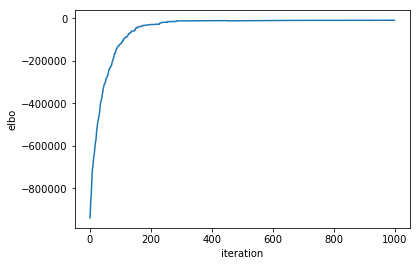

In [104]:
Pi_computed = tau[:,0]/(tau[:,0] + tau[:,1])
round_nu = np.round(nu*(nu>=0.9) + nu*(nu<=0.1)) + nu*(nu>=0.1)*(nu<=0.9)
print('Z (unpermuted): \n', Z[0:10])

# Find the minimizing permutation.
accuracy_mat = [[ np.sum(np.abs(Z[:, i] - nu[:, j]))/Num_samples for i in range(K_inf) ]
                  for j in range(K_inf) ]
perm_tmp = np.argmin(accuracy_mat, 1)

# check that we have a true permuation
if len(perm_tmp) == len(set(perm_tmp)):  
    perm = perm_tmp
else: 
    print('** procedure did not give a true permutation')
    perm = [2,0,1]

print('permutation: ', perm)
    
# print Z (permuted) and nu
print('Z (permuted) \n', Z[0:10, perm])
print('round_nu \n', round_nu[0:10,:])

print('l1 error (after permutation): ', \
    [ np.sum(np.abs(Z[:, perm[i]] - nu[:, i]))/Num_samples for i in range(K_inf) ])

print('\n')
print('true A (permuted): \n', A[perm, :])
print('phi_mu: \n', phi_mu.transpose())

print('\n')
print('true Pi (permuted): ', Pi)
print('computed Pi: ', Pi_computed)
plt.clf()
plt.plot(elbo[:iter_ran])
plt.xlabel('iteration')
plt.ylabel('elbo')
plt.show()

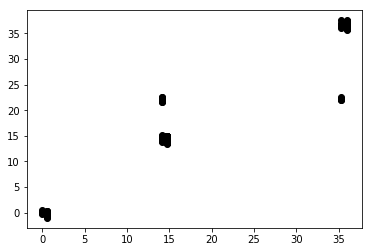

In [93]:
pred_x = np.dot(nu, phi_mu.transpose())
col = 0
plt.clf()
plt.plot(pred_x[:, col], X[:, col], 'ko')
plt.show()

    phi_mu_old = deepcopy(phi_mu)
    phi_var_old = deepcopy(phi_var)
    tau_old = deepcopy(tau)

    # compute step-size
    """if step_size < 10**(-4): 
        step_size = 10**(-1)
    else: 
        step_size = 1/(1/step_size+1)
    """
    step_size = (iter_ran+1)**(-0.6)
    #step_size = 1
    
    # update global parameters
    phi_mu = phi_mu_old * (1-step_size) + phi_mu * step_size
    phi_var = phi_var_old * (1-step_size) + phi_var * step_size
    tau = tau_old * (1-step_size) + tau * step_size
